In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import glob

sys.path.append("/data/laue34/LaueIndex_XML_python/Example/jupyter_files/py_func/")
pathbins = '/data/laue34/LaueIndex_XML_python/Example/jupyter_files/py_func/linux/'

import fn_LaueGopipline2 as LGp
# without this command the code does not run; I could not figure why
%pylab inline   

#%matplotlib widget





Populating the interactive namespace from numpy and matplotlib


In [2]:
# set_file_range

scanPoint = np.arange(1,3,1)
depthRange = np.arange(100, 102, 1)
#depthRange = np.nan #if no depthRange

#set data folder for reading
filefolder = '/data/laue34/repacks_10mn/consgeo/'
filename_ = 'out_'

#set data folder for saving results
savefolder = '/data/laue34/LaueIndex_XML_python/Example/jupyter_files/results/out_index1/'
geo_file = '/data/laue34/LaueIndex_XML_python/Example/jupyter_files/xml_index/geoN_2023-02-07_19-19-10.xml'
cryst_file = '/data/laue34/LaueIndex_XML_python/Example/jupyter_files/xml_index/Ni.xml'

#generate the list of files name for analysis
fnames = []

if np.isnan(depthRange).any():
    for ii in range(len(scanPoint)):
        # if the depthRange exist
        fnames.append(filename_ + str(scanPoint[ii]))
else:
    for ii in range(len(scanPoint)):
        for jj in range (len(depthRange)):
            fnames.append(filename_ + str(scanPoint[ii]) + '_' + str(depthRange[jj]))

print(fnames)    



#### just for testing clean the folder before running the next cell, as it will not show up what is wrong


files = glob.glob(savefolder + '*')
for f in files:
    os.remove(f)

['out_1_100', 'out_1_101', 'out_2_100', 'out_2_101']


In [9]:
# !rm -r ./peaksXY
# !mkdir peaksXY


# To crop the detector range 
x1 = 0 # min is 0
x2 = 2047 # max is 2047 full range
y1 = 0 # min is 0
y2 = 2047 # max is 2047 full range

depth = 0 # in case the depth coordinate is not exist optional to change the depth variable during analysis; should be as a vector 

# fitX_all = []
# fitY_all = []
# Inten_all = []

fnamesnotdone = []
notdone = []


for ii in range(len(fnames)):
    filename = filefolder+ fnames[ii]+'.h5'
    #filenamesave = '/clhome/DSHEYFER/jupyter_analysis/ML_Laue/peak_seearch/XEOL1222_HASlongcropped/' + fnames[ii] + '.h5'
    with h5py.File(filename, 'r') as f:
        data_2D = np.float32(f['entry1/data/data'])[y1:y2+1,x1:x2+1]
        try:
            depth = np.float32(f['entry1/depth'])[:]
        #data_2D[data_2D >= 65535] = data_2D.mean()
        except:
            print('no depth found')
    temph5save = 'temp.h5' # or filenamesave if saving the cropped file out of the full file
    
    LGp.fn_genericJonsH5(filename, temph5save, x1,x2,y1,y2, depth, data_2D)
    # to run peak search program
    
    try:
        path_peaksearch = pathbins+'peaksearch'

        ps_boxsize = 18.0;
        ps_maxRfactor = 0.5;
        ps_min_size = 1.13;
        ps_max_peaks = 300;
        ps_smooth = 1;
        ps_minSeparation = 10;
        ps_threshold = 50;  # if '' then threshold is nan

        ps_peaktype = 'Lorentzian'
        ps_peaktype = 'Gaussian' # Lorentzian
        ps_mask = ''
        ps_input = temph5save
        ps_out = savefolder+'peaks_'+ fnames[ii]+'.txt'
        path_peaks2qs =  pathbins+'pixels2qs'
        pq_geo = geo_file
        pq_cryst = cryst_file
        pq_input = ps_out
        pq_out = savefolder+'p2q_'+ fnames[ii]+'.txt'

        path_index = pathbins +'euler'
        ix_keVmaxCalc = 17.2
        ix_keVmaxTest = 35.0
        ix_angleTolerance = 0.1
        ix_h = 0
        ix_k = 0
        ix_l = 2
        ix_cone = 72.0
        ix_input = pq_out
        ix_out = savefolder +'index_'+ fnames[ii]+'.txt'


        LGp.fn_peakSearch(path_peaksearch, ps_boxsize, ps_maxRfactor, ps_min_size, ps_minSeparation, ps_smooth, ps_threshold, ps_max_peaks, ps_mask, ps_input, ps_out)
        LGp.fn_peaks2qs(path_peaks2qs, pq_geo, pq_cryst, pq_input, pq_out)
        LGp.fn_Index(path_index, ix_keVmaxCalc, ix_keVmaxTest, ix_angleTolerance, ix_h, ix_k, ix_l, ix_cone, ix_input, ix_out)
        
        
        # if I do not run this function then I do not know if files are actually saved
        Peaks_calc = LGp.fn_readIndex(ix_out, 0) # 1 is to show the output

    except:
        print("ERROR: " + filename)
        notdone.append(ii)
        fnamesnotdone.append(filename)



/data/laue34/LaueIndex_XML_python/Example/jupyter_files/results/out_index1/p2q_out_1_100.txt saved
Found 1 patterns
/data/laue34/LaueIndex_XML_python/Example/jupyter_files/results/out_index1/p2q_out_1_101.txt saved
Found 1 patterns
/data/laue34/LaueIndex_XML_python/Example/jupyter_files/results/out_index1/p2q_out_2_100.txt saved
Found 1 patterns
/data/laue34/LaueIndex_XML_python/Example/jupyter_files/results/out_index1/p2q_out_2_101.txt saved
Found 1 patterns


In [10]:
#%pylab inline
#matplotlib widget

Found 1 patterns


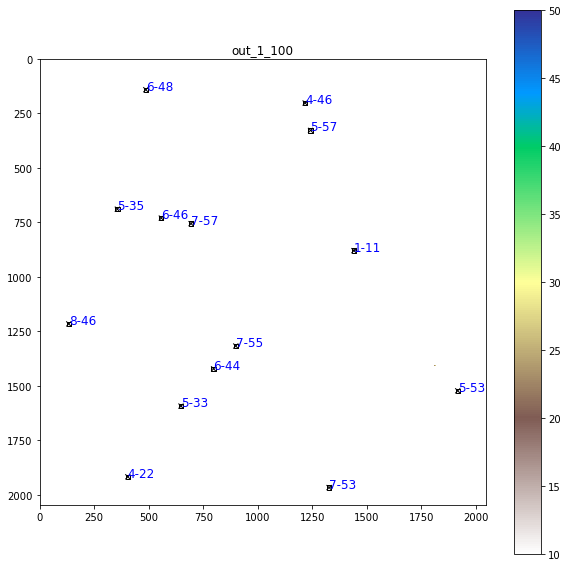

In [11]:
# show some results 


to_plot = [0]
for tt in range(len(to_plot)):
    ii = to_plot[tt]
    filename = filefolder+ fnames[ii]+'.h5'
    ps_out = savefolder+'peaks_'+ fnames[ii]+'.txt'
    ix_out = savefolder +'index_'+ fnames[ii]+'.txt'

    [fitX, fitY, Ipeak] = LGp.fn_readXY(ps_out)
    Peaks_calc = LGp.fn_readIndex(ix_out, 0) # 1 is to show the output
    
    #some extra parameters read from the index.txt files
    #[astar_all, bstar_all, cstar_all, goodness_index, rms_error_index, Nind] = LGp.fn_read_abc(ix_out)
    #print(astar_all)
    #print(bstar_all)
    #print(cstar_all)
    #print(Nind)

    fig = plt.figure(figsize = (10,10))
    ax1 = fig.add_subplot(1,1,1)
    img1 = ax1.imshow(data_2D, cmap = 'terrain_r', vmin = 10, vmax = 50)
    ax1.set_aspect(1)
    ax1.set_title(fnames[ii])
    plt.colorbar(img1)

    d = 10
    ccolors = ['b', 'r', 'm', 'g', 'k']
    for ii in range(len(fitX)):
        xcen = fitX[ii]
        ycen = fitY[ii]
        ax1.plot([xcen-d, xcen-d, xcen+d, xcen+d, xcen-d],[ycen-d, ycen+d, ycen+d, ycen-d, ycen-d], linewidth = 1, color = 'k')
        ax1.plot([xcen-d, xcen+d],[ycen-d, ycen+d], linewidth = 1, color = 'k')
        ax1.plot([xcen-d, xcen+d],[ycen+d, ycen-d], linewidth = 1, color = 'k')

    for ii in range(len(Peaks_calc)):
        for jj in range(len(Peaks_calc[ii])):
            xcen = fitX[int(Peaks_calc[ii][jj][10])]
            ycen = fitY[int(Peaks_calc[ii][jj][10])]
            str_hkl = str(int(Peaks_calc[ii][jj][4])) + str(int(Peaks_calc[ii][jj][5])) + str(int(Peaks_calc[ii][jj][6]))
            #print(str_hkl)
            ax1.text(xcen, ycen, str_hkl, color = ccolors[ii], fontsize = 12)
            
            
#plt.savefig('Laue_8396.eps', format='eps', dpi = 600)


